In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

from utils import create_image, create_image_table


matfile = loadmat('face.mat')
data = matfile['X']

# create labels, there are 10 images of each face
labels = []
for i in range(52):
    labels.extend([i] * 10)
labels = np.array(labels)

# Split data into training and testing set. There are 10 images of each face, 520 in total.
# pick first 8 as training set and rest 2 as test set for all faces
d, N = data.shape
train_idx = []
test_idx = []
for i in range(N//10):
    s = i * 10
    train_idx.extend(list(range(s, s+8)))
    test_idx.extend(list(range(s+8, s+10)))


X_train = np.take(data, train_idx, axis=1)
X_test = np.take(data, test_idx, axis=1)

y_train = np.take(labels, train_idx, axis=0)
y_test = np.take(labels, test_idx, axis=0)
print(X_train.shape)
print(y_train.shape)

(2576, 416)
(416,)


In [2]:
# function to perform PCA
# function to perform LDA
# function to perform NN 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


def pca_step(data, n):
    """Perform dimension reduction with PCA"""
    pca = PCA(n_components=n)
    reduced_data = pca.fit_transform(data.T)  # have to transpose since sklearn wants (N, d)
    return reduced_data.T, pca

def lda_step(data, labels, n):
    """Perform dimension reduction with LDA"""
    lda = LDA(n_components=n, solver='eigen')
    lda.fit(data.T, labels)
    reduced_data = lda.transform(data.T)
    return reduced_data.T, lda

def predict(X_train, y_train, X_test):
    nn = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
    nn.fit(X_train.T, y_train)
    preds = nn.predict(X_test.T)
    return preds

def accuracy(prediction, truth):
    assert len(prediction) == len(truth), 'prediction length != labels length'
    acc = np.count_nonzero(prediction == truth) / len(prediction)
    return round(acc, 4)

def pipeline(m_pca, m_lda):
    r_pca, pca_obj = pca_step(X_train, m_pca)
    r_lda, lda_obj = lda_step(r_pca, y_train, m_lda)
    X_test_lda = lda_obj.transform(pca_obj.transform(X_test.T)).T
    preds = predict(r_lda, y_train, X_test_lda)
    acc = accuracy(preds, y_test)
    return acc

In [72]:
pipeline(70, 25)

0.8654

In [73]:
# implement gridsearch to find out M_pca and M_lda that work well
# present results in a heatmap
pca_space = np.arange(45, 85, 5)
lda_space = np.arange(10, 45, 5)
accs = np.zeros([len(pca_space),len(lda_space)])
for i, m_pca in enumerate(pca_space):
    for j, m_lda in enumerate(lda_space):
        if m_lda > m_pca:
            continue
        acc = pipeline(m_pca, m_lda)
        accs[i, j] = acc


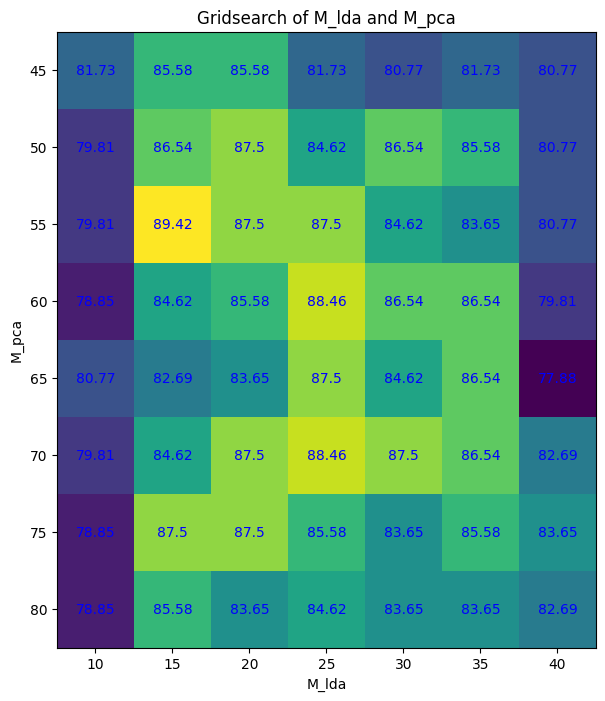

In [74]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(accs)
ax.set_yticks(np.arange(len(pca_space)), labels=pca_space)
ax.set_ylabel('M_pca')
ax.set_xticks(np.arange(len(lda_space)), labels=lda_space)
ax.set_xlabel('M_lda')
for i in range(len(pca_space)):
    for j in range(len(lda_space)):
        text = ax.text(j, i, round(accs[i, j] * 100, 2),
                       ha="center", va="center", color="b")

ax.set_title('Gridsearch of M_lda and M_pca')
fig.savefig('images/gridsearch.png')

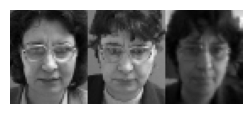

In [92]:
# it seems that best values are M_lda 25 and M_pca 60
create_image_table(X_train[:, 23*8:23*8+3], 3, figsize=3)

0.9038461538461539


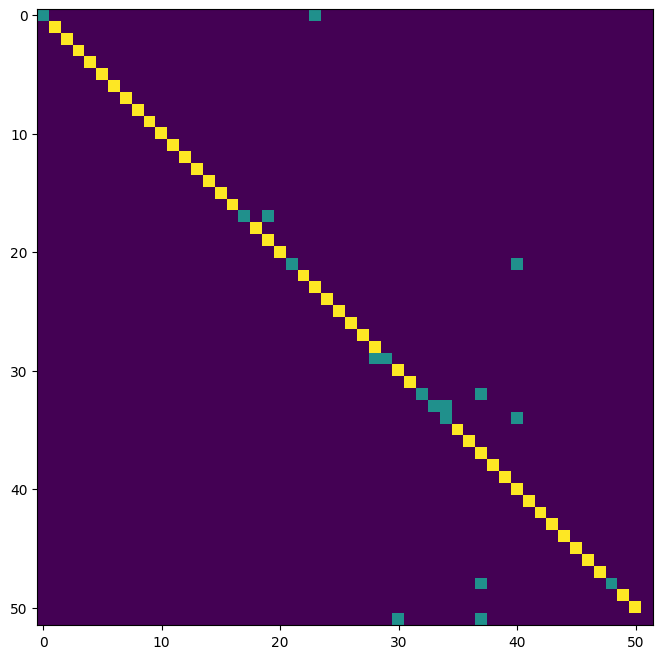

In [86]:
# create confusion matrix with like 10 classes, showing what they were predicted as
r_pca, pca_obj = pca_step(X_train, 55)
r_lda, lda_obj = lda_step(r_pca, y_train, 15)

# take first 10 classes of test data
n = 52  # n of faces
L = n * 2  # how many samples to take
test_data = X_test[:, :L]
test_labels = y_test[:L]

# transform and run prediction
lda_test = lda_obj.transform(pca_obj.transform(test_data.T)).T
preds = predict(r_lda, y_train, lda_test)

# count correctly and mi
results = np.zeros((n,n))
for i in range(n):
    results[i, preds[i * 2]] += 1
    results[i, preds[(i * 2) + 1]] += 1

fig, ax = plt.subplots(figsize=(8,8))
print(np.count_nonzero(preds == y_test) / len(y_test))
ax.imshow(results)
#fig.savefig('images/pca-lda-cf.png')

### Ensemble model

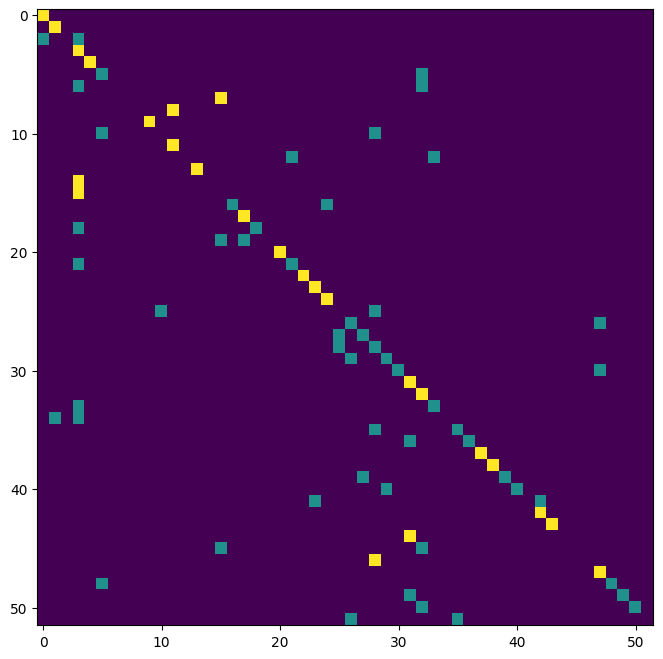

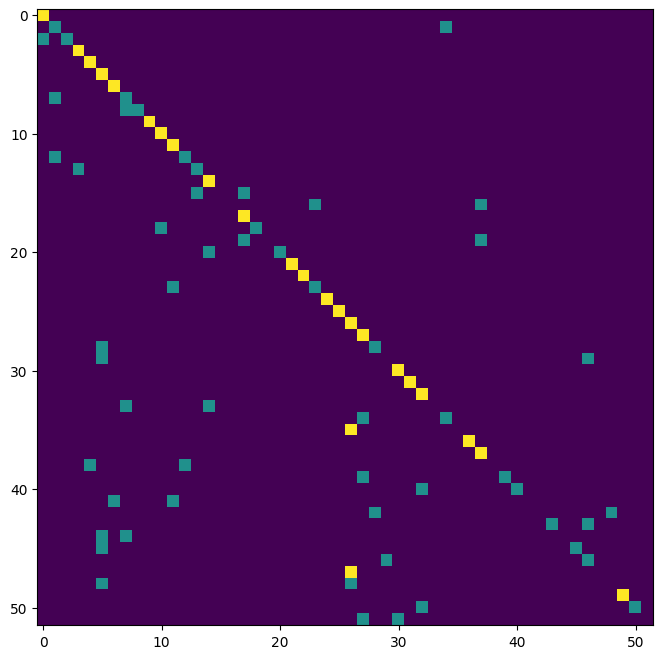

In [79]:
def plot_cf(probs):
    """Helper function to plot the confusion matrix from the output of ensemble model"""
    n = 52  # amount of classes
    p = np.argmax(probs, axis=1)  # get predicted class
    results = np.zeros((n,n))
    for i in range(n):
        results[i, p[i * 2]] += 1
        results[i, p[(i*2) + 1]] += 1
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(results);

def ensemble_acc(probs):
    """Helper function to output accuracy of ensemble predictions"""
    p = np.argmax(probs, axis=1)
    acc = np.count_nonzero(p == y_test) / len(y_test)
    return round(acc, 3)


class BagWeakLearner:

    def __init__(self, M_pca, M_lda):
        self.pca = PCA(n_components=M_pca)
        self.lda = LDA(n_components=M_lda)
        self.nn = KNeighborsClassifier(n_neighbors=3, algorithm='brute')

    def fit(self, X_train, y_train):
        pca_data = self.pca.fit_transform(X_train.T)
        lda_data = self.lda.fit_transform(pca_data, y_train)
        self.nn.fit(lda_data, y_train)

    def predict(self, test_data):
        pca_d = self.pca.transform(test_data)
        lda_d = self.lda.transform(pca_d)
        probs = self.nn.predict_proba(lda_d)
        return probs


class BaggingEnsemble:
    """
    Ensemble model that randomly takes sets of samples (bagging) of the training data,
    and performs the full PCA-LDA-NN pipeline on those sets"""

    def __init__(self, n_models, p, m_lda=20):
        self.n_models = n_models
        self.p = p
        self.m_lda = m_lda
        self.pca = PCA(n_components=51).fit(X_train.T)
        self.pca_data = self.pca.transform(X_train.T).T
        self.learners = self.create_learners()
    
    def split_data(self):
        # select random images from every class
        assert 1 <= self.p <= 8
        images, labels = [], []
        for c in range(52):
            indexes = [np.random.choice(range(8)) for _ in range(self.p)]  # which indexes of 0-7 to take
            images.extend([self.pca_data[:, c*8 + i].reshape(-1, 1) for i in indexes])  # take for this image
            labels.extend([c] * len(indexes))
        split = np.hstack(images)
        return split, labels

    def create_learners(self):
        learners = []
        for i in range(self.n_models):
            model = BagWeakLearner(35, self.m_lda)
            s, l = self.split_data()
            model.fit(s, l)
            learners.append(model)
        return learners

    def predict_once(self):
        # report accuracy per learner
        test_data = self.pca.transform(X_test.T)
        accs = []
        for model in self.learners:
            probs = model.predict(test_data)
            acc = ensemble_acc(probs)
            accs.append(acc)
        return accs

    def individual_cf(self):
        # collect probabilities from each weak learner
        test_data = self.pca.transform(X_test.T)
        for model in self.learners[:2]:
            probs = np.zeros((len(test_data), 52))
            probs += model.predict(test_data)
            plot_cf(probs)
        
        

    def predict(self):
        # collect probabilities from each weak learner
        test_data = self.pca.transform(X_test.T)
        probs = np.zeros((len(test_data), 52))
        for model in self.learners:
            probs += model.predict(test_data)
        
        return probs / self.n_models


b = BaggingEnsemble(40, 4, m_lda=12)
b.individual_cf()
#p = b.predict()
#print(ensemble_acc(p))
#plot_cf(p)

In [43]:
accs = b.predict_once()
print(np.mean(accs))

0.49589999999999995


In [75]:
class FeatureWeakLearner:
    """
    Instead of performing PCA, this learner is given a weight
    matrix that is a subspace in itself. The learner will use that 
    to project data.
    """

    def __init__(self, W_pca, M_lda):
        self.W_pca = W_pca
        self.lda = LDA(n_components = M_lda)
        self.nn = KNeighborsClassifier(n_neighbors=3, algorithm='brute')

    def fit(self, X_train, y_train):
        """Cast data first into the pca subspace, and then fit the LDA model"""
        pca_data = self.W_pca @ X_train
        lda_data = self.lda.fit_transform(pca_data.T, y_train)
        self.nn.fit(lda_data, y_train)

    def predict(self, test_data):
        pca_d = self.W_pca @ test_data
        lda_d = self.lda.transform(pca_d.T)
        probs = self.nn.predict_proba(lda_d)
        return probs

class FeatureEnsemble:
    """An ensemble model that uses randomised feature spaces"""
    def __init__(self, n_models, M_0=15, M_1=25):
        self.n_models = n_models
        self.M_0 = M_0
        self.M_1 = M_1
        self.pca_size = X_train.shape[1] - 1  # N-1
        self.pca = PCA(n_components=self.pca_size).fit(X_train.T)
        self.X_train_mr = (X_train.T - self.pca.mean_).T  # mean reduced
        self.pca_data = self.pca.transform(X_train.T)
        self.learners = self.create_learners()

    def split_data(self):
        w_pca = self.pca.components_  # the eigenvectors
        # take first eigenvectors, and select the rest randomly
        first_eigvecs = w_pca[:self.M_0, :]
        ix = np.random.choice(range(self.M_0, self.pca_size), size=self.M_1, replace=False)
        next_vectors = np.take(w_pca, ix, axis=0)
        w_sub = np.vstack([first_eigvecs, next_vectors])
        return w_sub

    def create_learners(self):
        """Initialize multiple weak learners, each of which takes a random subspace of the 
        pca space, and builds an LDA model based on that space.
        """
        learners = []
        for _ in range(self.n_models):
            w_subspace = self.split_data()
            learner = FeatureWeakLearner(w_subspace, 20)
            learner.fit(self.X_train_mr, y_train)
            learners.append(learner)
        return learners

    def predict_once(self):
        # report accuracy per learner
        test_data = (X_test.T - self.pca.mean_).T
        accs = []
        for model in self.learners:
            probs = model.predict(test_data)
            acc = ensemble_acc(probs)
            accs.append(acc)
        return accs
    

    def predict(self):
        # subtract mean of train data
        mean_reduced = (X_test.T - self.pca.mean_).T
        probs = np.zeros((X_test.shape[1], 52))
        for learner in self.learners:
            probs += learner.predict(mean_reduced)
        return probs / self.n_models


f = FeatureEnsemble(50, M_0=15, M_1=25)
#ps = f.predict()
#acc = ensemble_acc(ps)
#print(f'{acc=}')
#plot_cf(ps)
a = f.predict_once()
print(np.mean(a))
ensemble_acc(f.predict())

0.53592


0.788